In [1]:
import numpy as np
import msprime
import tskit
import sys
sys.path.append("../")
from tsimpute import beagle_numba
from tsimpute import measures

In [2]:
N = 1000
L = 1e7
rho = 1e-9
mu = 1e-9
ts = msprime.sim_mutations(
    msprime.sim_ancestry(
        N,
        sequence_length=L,
        discrete_genome=True,
        recombination_rate=rho,
        population_size=1e4,
    ),
    rate=mu,
)
ts

In [3]:
num_biallelic_sites = 0
num_nonbiallelic_sites = 0
for var in ts.variants():
    if len(var.alleles) == 2:
        num_biallelic_sites += 1
    else:
        num_nonbiallelic_sites += 1
assert ts.num_sites == num_biallelic_sites + num_nonbiallelic_sites
print(f"Biallelic: {num_biallelic_sites}")
print(f"Non-biallelic: {num_nonbiallelic_sites}")

Biallelic: 3396
Non-biallelic: 0


In [4]:
ref_individuals = np.arange(ts.num_individuals - 1)
query_individuals = np.array([ts.num_individuals - 1])

In [5]:
site_mask = np.zeros(ts.num_sites, dtype=bool)
for i in np.arange(ts.num_sites)[::100]:
    site_mask[i:(i + 10)] = 1
num_masked_sites = np.sum(site_mask)
num_masked_sites

340

In [6]:
ref_vcf_file = "ref.vcf"
ref_individual_names = ["tsk_" + str(x) for x in ref_individuals]
with open(ref_vcf_file, 'w') as f:
    ts.write_vcf(
        output=f,
        individuals=ref_individuals,
        individual_names=ref_individual_names,
    )

In [7]:
query_vcf_file = "query.vcf"
query_individual_names = ["tsk_" + str(x) for x in query_individuals]
with open(query_vcf_file, 'w') as f:
    ts.write_vcf(
        output=f,
        individuals=query_individuals,
        individual_names=query_individual_names,
        site_mask=site_mask,
    )

In [8]:
beagle_out_prefix = "test"
!java -jar ../ext/beagle.27Jan18.7e1.jar gprobs=true cluster=0 ref="$ref_vcf_file" gt="$query_vcf_file" out="$beagle_out_prefix"
!tabix "$beagle_out_prefix".vcf.gz

beagle.27Jan18.7e1.jar (version 4.1)
Copyright (C) 2014-2015 Brian L. Browning
Enter "java -jar beagle.27Jan18.7e1.jar" for a summary of command line arguments.
Start time: 07:03 PM GMT on 23 Mar 2025

Command line: java -Xmx4096m -jar beagle.jar
  gprobs=true
  cluster=0
  ref=ref.vcf
  gt=query.vcf
  out=test

No genetic map is specified: using 1 cM = 1 Mb

reference samples:     999
target samples:          1

Window 1 [ 1:13829-9999801 ]
reference markers:    3396
target markers:       3056

Imputation time (this window): 0 seconds

Number of reference markers:      3396
Number of target markers:         3056
Total time for imputation:     0 seconds
Total run time:                1 second

End time: 07:04 PM GMT on 23 Mar 2025
beagle.27Jan18.7e1.jar (version 4.1) finished


In [9]:
from cyvcf2 import VCF
imp_vcf_file = beagle_out_prefix + ".vcf.gz"
gp_00_beagle = np.zeros(num_masked_sites, dtype=np.float64)
gp_01_beagle = np.zeros(num_masked_sites, dtype=np.float64)
gp_11_beagle = np.zeros(num_masked_sites, dtype=np.float64)
i = 0
for var in VCF(imp_vcf_file):
    if var.INFO.get('IMP', False):
        gps = var.format('GP')
        gp_00_beagle[i] = gps[0][0]
        gp_01_beagle[i] = gps[0][1]
        gp_11_beagle[i] = gps[0][2]
        i += 1

In [10]:
ne = 1e6
err_rate = 1e-4
cm = beagle_numba.convert_to_cm(ts.sites_position)
trans_probs = beagle_numba.get_transition_probs(cm, h=ts.num_samples, ne=ne)
mismatch_probs = beagle_numba.get_mismatch_probs(ts.num_sites, error_rate=err_rate)

ref_samples = []
for i in ref_individuals:
    node_ids = ts.individual(id_=i).nodes
    assert len(node_ids) == 2
    ref_samples.append(node_ids[0])
    ref_samples.append(node_ids[1])
ref_samples = np.array(ref_samples, dtype=np.int32)

query_samples = []
for i in query_individuals:
    node_ids = ts.individual(id_=i).nodes
    assert len(node_ids) == 2
    query_samples.append(node_ids[0])
    query_samples.append(node_ids[1])
query_samples = np.array(query_samples, dtype=np.int32)

ref_h = ts.genotype_matrix(alleles=tskit.ALLELES_ACGT, samples=ref_samples)
query_h = ts.genotype_matrix(alleles=tskit.ALLELES_ACGT, samples=query_samples)
query_h[site_mask, :] = tskit.MISSING_DATA

a1, ap1 = beagle_numba.run_interpolation_beagle(
    ref_h=ref_h,
    query_h=query_h[:, 0],
    pos_all=ts.sites_position,
    ne=ne,
    error_rate=err_rate,
    use_threshold=False,
)
a2, ap2 = beagle_numba.run_interpolation_beagle(
    ref_h=ref_h,
    query_h=query_h[:, 1],
    pos_all=ts.sites_position,
    ne=ne,
    error_rate=err_rate,
    use_threshold=False,
)

/Users/shingzhan/Projects/tsimpute/notebooks/../tsimpute/beagle_numba.py:576: UserWarning: This function is experimental and not fully tested.
  warnings.warn("This function is experimental and not fully tested.", stacklevel=1)
/Users/shingzhan/Projects/tsimpute/notebooks/../tsimpute/beagle_numba.py:577: UserWarning: Check the reference and query haplotypes use the same allele encoding.
  warnings.warn(
/Users/shingzhan/Projects/tsimpute/notebooks/../tsimpute/beagle_numba.py:576: UserWarning: This function is experimental and not fully tested.
  warnings.warn("This function is experimental and not fully tested.", stacklevel=1)
/Users/shingzhan/Projects/tsimpute/notebooks/../tsimpute/beagle_numba.py:577: UserWarning: Check the reference and query haplotypes use the same allele encoding.
  warnings.warn(


In [11]:
refs = np.zeros(num_masked_sites, dtype=np.int32)
i = 0
for site_id in np.where(site_mask)[0]:
    site = ts.site(id_=site_id)
    refs[i] = "ACGT".index(site.ancestral_state)
    i += 1

array([0, 1, 1, 3, 0, 3, 1, 2, 2, 1, 2, 2, 1, 1, 0, 3, 2, 2, 0, 2, 3, 2,
       3, 1, 3, 1, 1, 2, 3, 3, 3, 2, 0, 3, 1, 3, 1, 0, 1, 1, 3, 1, 2, 0,
       1, 3, 2, 3, 2, 1, 0, 3, 2, 3, 0, 2, 0, 0, 1, 3, 2, 1, 1, 0, 0, 2,
       1, 1, 1, 1, 3, 0, 0, 3, 0, 2, 3, 2, 0, 2, 1, 2, 0, 3, 3, 1, 2, 2,
       2, 2, 2, 0, 1, 1, 1, 3, 0, 2, 3, 3, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3,
       2, 2, 1, 2, 1, 2, 2, 2, 3, 0, 3, 3, 0, 2, 0, 1, 3, 3, 0, 1, 0, 0,
       0, 0, 1, 1, 3, 1, 1, 0, 3, 2, 2, 3, 3, 1, 0, 0, 0, 0, 1, 1, 2, 3,
       1, 1, 3, 0, 0, 3, 1, 2, 3, 1, 3, 1, 1, 0, 2, 1, 3, 3, 1, 1, 2, 1,
       2, 2, 0, 0, 3, 0, 1, 1, 1, 3, 2, 0, 2, 3, 2, 1, 0, 3, 2, 0, 1, 2,
       0, 0, 1, 3, 0, 1, 0, 0, 1, 0, 1, 3, 0, 3, 3, 2, 2, 1, 2, 0, 0, 1,
       3, 1, 1, 0, 3, 0, 2, 0, 0, 3, 1, 3, 0, 1, 1, 0, 3, 0, 0, 2, 2, 0,
       1, 0, 2, 3, 1, 3, 0, 3, 2, 3, 0, 0, 1, 0, 0, 2, 2, 3, 3, 0, 3, 3,
       2, 1, 3, 2, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 3, 2, 1, 3, 3,
       0, 1, 0, 2, 2, 2, 3, 1, 3, 2, 2, 0, 3, 0, 2,

In [12]:
gp_00_impl = np.zeros(num_masked_sites, dtype=np.float64)
gp_01_impl = np.zeros(num_masked_sites, dtype=np.float64)
gp_11_impl = np.zeros(num_masked_sites, dtype=np.float64)
for i in range(num_masked_sites):
    dosage_probs, _ = measures.compute_individual_scores(
        alleles_1=np.array([a1[i]]),
        alleles_2=np.array([a2[i]]),
        allele_probs_1=np.array([ap1[i]]),
        allele_probs_2=np.array([ap2[i]]),
        ref=refs[i],
    )
    gp_00_impl[i] = dosage_probs[0, 0]
    gp_01_impl[i] = dosage_probs[0, 1]
    gp_11_impl[i] = dosage_probs[0, 2]

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

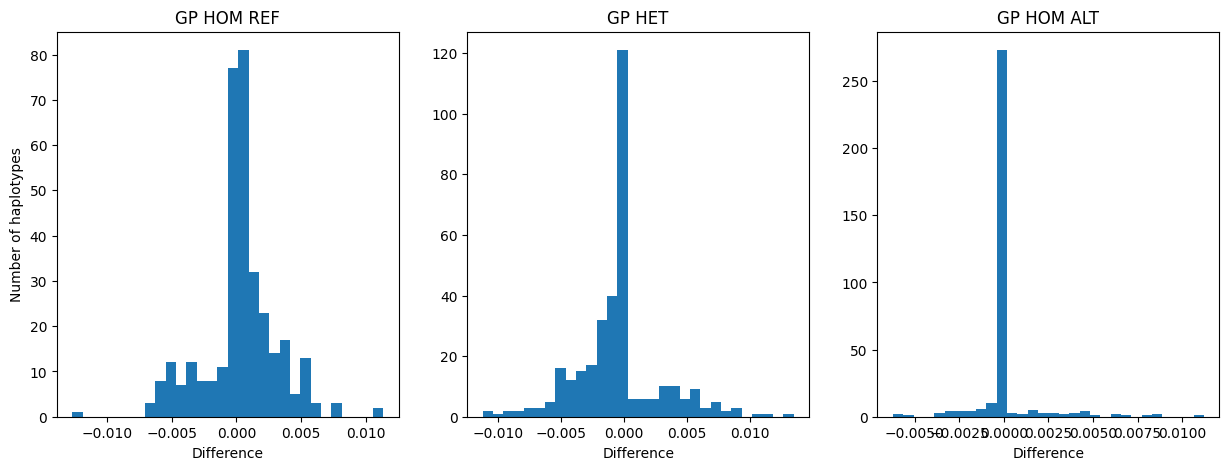

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title("GP HOM REF")
ax[0].set_ylabel("Number of haplotypes")
ax[0].set_xlabel("Difference")
ax[0].hist(gp_00_beagle - gp_00_impl, bins=30)
ax[1].set_title("GP HET")
ax[1].set_xlabel("Difference")
ax[1].hist(gp_01_beagle - gp_01_impl, bins=30)
ax[2].set_title("GP HOM ALT")
ax[2].set_xlabel("Difference")
ax[2].hist(gp_11_beagle - gp_11_impl, bins=30);

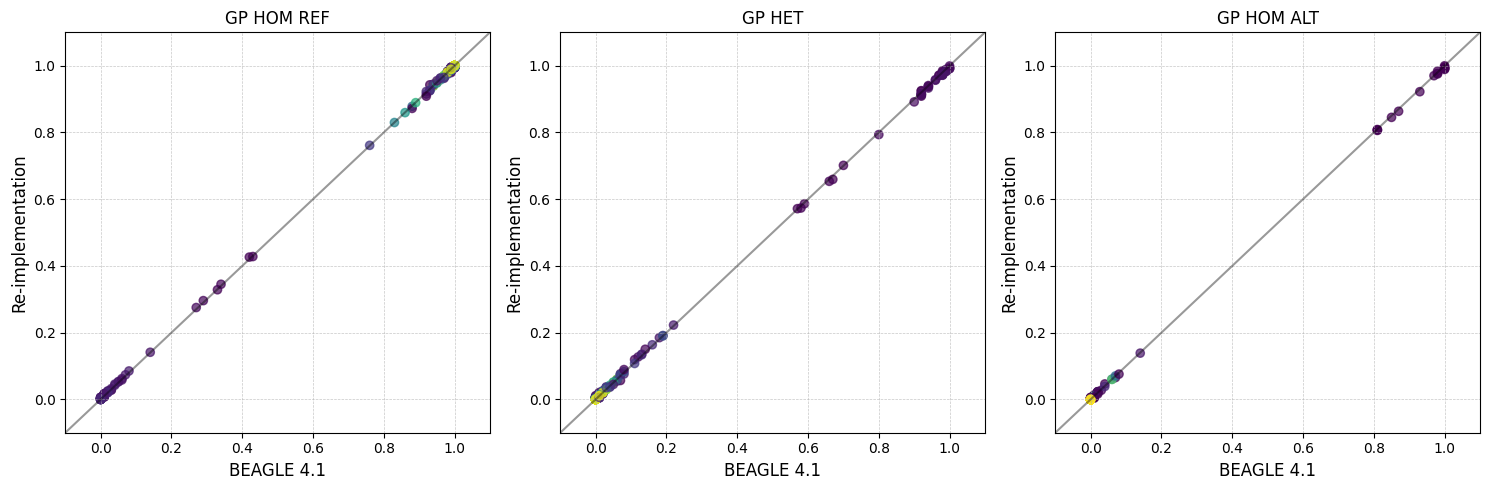

In [15]:
def plot_density_scatter(ax, x, y, xlabel, ylabel, title, cmap):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)(xy)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.axline((0, 0), slope=1, color="black", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.scatter(x, y, c=kde, cmap=cmap, alpha=0.7)


plt.style.use('default')
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_density_scatter(
    title="GP HOM REF",
    x=gp_00_beagle,
    y=gp_00_impl,
    xlabel="BEAGLE 4.1",
    ylabel="Re-implementation",
    cmap="viridis",
    ax=ax[0],
)
plot_density_scatter(
    title="GP HET",
    x=gp_01_beagle,
    y=gp_01_impl,
    xlabel="BEAGLE 4.1",
    ylabel="Re-implementation",
    cmap="viridis",
    ax=ax[1],
)
plot_density_scatter(
    title="GP HOM ALT",
    x=gp_11_beagle,
    y=gp_11_impl,
    xlabel="BEAGLE 4.1",
    ylabel="Re-implementation",
    cmap="viridis",
    ax=ax[2],
)
plt.tight_layout()
plt.show()